In [362]:
# Ставим библиотеки
from utils import *
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

from navec import Navec
from slovnet.model.emb import NavecEmbedding

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import pymorphy2

import warnings

nltk.download("punkt")
nltk.download("stopwords")
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (15, 7)

# Загружаем стоп-слова и инициализируем лемматизатор
stop_words = set(stopwords.words('russian'))
morph = pymorphy2.MorphAnalyzer()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/abdulrasidmukuev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/abdulrasidmukuev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [363]:
# Скачиваем исходный файл с вакансиями
raw_df = pd.read_excel("data.xlsx", dtype="str")
raw_df.tail()

,id,description,skills_str
16995,98b5bd15-d1f6-11ec-8c63-57fc951f3846,NaN,"Исполнительность, Ответственность, Разработка ..."
16996,b715d743-dea9-11e6-853f-bf2cfe8c828d,NaN,"машиностроение, ремонт судовых механизмов, раз..."
16997,5d3d8182-80a2-11e9-8ba1-bf2cfe8c828d,NaN,"Фрезеровка, Работа в тисках, Обработка деталей..."
16998,a2d50a52-ab22-11ea-94f4-bf2cfe8c828d,NaN,"соблюдение норм, внутренний трудовой распорядо..."
16999,8d0b6c02-cb11-11ea-94f4-bf2cfe8c828d,NaN,"знание правил ручной резки, работа с одеждой и..."


In [364]:
# Избавляемся от вакансий без описания
df = raw_df.dropna(subset="description")
df.tail()

,id,description,skills_str
16916,31220962,Обязанности: Верстка и дизайн рекламной прод...,"Верстка, Дизайн, Разработка логотипов, Предпеч..."
16917,31285209,Обязанности: - проведение переговоров с предст...,"переговоры с организациями, разработка меропри..."
16918,40252884,"Обязанности: Управление группой продукции, ра...","управление продукцией, анализ потребностей кли..."
16919,23978165,"Обязанности: работа с сетевыми магазинами, по...","работа с сетевыми магазинами, выкладка продукц..."
16920,37498527,Обязанности: Поиск потенциальных клиентов по ...,"Поиск клиентов, Ведение клиента, Участие в тен..."


In [365]:
# Преобразуем датафрейм в BIO-нотацию
tagged_dataframes = [apply_to_row(row) for index, row in df.iterrows()]
result_df = pd.concat(tagged_dataframes).reset_index(drop=True)
result_df

,id,token,tag
0,16123526,обязанности,O
1,16123526,:,O
2,16123526,перевод,O
3,16123526,технической,O
4,16123526,документации,O
...,...,...,...
1985222,37498527,10:00-18:00,O
1985223,37498527,лояльное,O
1985224,37498527,и,O
1985225,37498527,грамотное,O


In [369]:
# Сохраним result_df в отдельный файл
result_df.to_csv("data_bio.csv", encoding="utf-16", index=False)

In [370]:
# Скачиваем сохраненный result_df
result_df = pd.read_csv("data_bio.csv", encoding="utf-16")
result_df

,id,token,tag
0,16123526,обязанности,O
1,16123526,:,O
2,16123526,перевод,O
3,16123526,технической,O
4,16123526,документации,O
...,...,...,...
1985222,37498527,10:00-18:00,O
1985223,37498527,лояльное,O
1985224,37498527,и,O
1985225,37498527,грамотное,O


In [371]:
# Получаем уникальные идентификаторы вакансий
unique_ids = result_df['id'].unique()

# Разделяем идентификаторы вакансий на тренировочную, валидационную и тестовую группы
train_ids, temp_ids = train_test_split(unique_ids, test_size=2959, random_state=42) 
val_ids, test_ids = train_test_split(temp_ids, test_size=1459, random_state=42) 

train_df = result_df[result_df['id'].isin(train_ids)]
val_df = result_df[result_df['id'].isin(val_ids)]
test_df = result_df[result_df['id'].isin(test_ids)]

# Проверяем размерность данных
print(f"Train size vacancies: {len(train_ids)}")
print(f"Validation size vacancies: {len(val_ids)}")
print(f"Test size vacancies: {len(test_ids)}")
print()
print(f"Train size tokens: {len(train_df)}")
print(f"Validation size tokens: {len(val_df)}")
print(f"Test size tokens: {len(test_df)}")

Train size vacancies: 8000
Validation size vacancies: 1500
Test size vacancies: 1459

Train size tokens: 1447011
Validation size tokens: 271767
Test size tokens: 266449


In [372]:
# Функция для базовой оценки 
def calc_baseline_accuracy(df):
    # Считаем, сколько раз тег совпал с "O"
    correct_predictions = df['tag'].value_counts().get('O', 0)
    # Общее количество предсказаний
    total_predictions = len(df)
    # Вычисляем точность
    accuracy = correct_predictions / total_predictions
    return accuracy

# Вычисляем точность для тренировочной, валидационной и тестовой выборок
print(f"Accuracy on training data: {calc_baseline_accuracy(train_df):.0%}")
print(f"Accuracy on validation data: {calc_baseline_accuracy(val_df):.0%}")
print(f"Accuracy on test data: {calc_baseline_accuracy(test_df):.0%}")

Accuracy on training data: 97%
Accuracy on validation data: 97%
Accuracy on test data: 96%


* Видно, что в данных существенный дизбаланс в сторону токенов без тегов, что свойственно для NER. Исходя из этого, базовую метрику качества Accuracy использовать нерелевантно, поэтому будем использовать Precision, Recall и F1 с макро-усреднением.

In [89]:
def calc_baseline_clf_metrics(df, mode=1):

    if mode == 1:
        predictions = np.random.choice(df["tag"].unique(), size=df.shape[0])
    elif mode == 2:
        predictions = np.random.choice(["B-SKILL", "I-SKILL"], size=df.shape[0])
    else:
        predictions = np.random.choice(["O"], size=df.shape[0])

    precision = precision_score(df["tag"], predictions, labels=["B-SKILL", "I-SKILL"], average="weighted")
    recall = recall_score(df["tag"], predictions, labels=["B-SKILL", "I-SKILL"], average="weighted")
    f1 = f1_score(df["tag"], predictions, labels=["B-SKILL", "I-SKILL"], average="weighted")

    return (precision, recall, f1)

# Вычисляем F1 для тренировочной, валидационной и тестовой выборок
print("F-мера, если выбирать теги случайно:")
print(f"F1 on training data: {calc_baseline_clf_metrics(train_df)[2]:.2%}")
print(f"F1 on validation data: {calc_baseline_clf_metrics(val_df)[2]:.2%}")
print(f"F1 on test data: {calc_baseline_clf_metrics(test_df)[2]:.2%}")
print()

print("F-мера, если выбирать случайно из 'B-SKILL' и 'I-SKILL':")
print(f"F1 on training data: {calc_baseline_clf_metrics(train_df, mode=2)[2]:.2%}")
print(f"F1 on validation data: {calc_baseline_clf_metrics(val_df, mode=2)[2]:.2%}")
print(f"F1 on test data: {calc_baseline_clf_metrics(test_df, mode=2)[2]:.2%}")
print()

print("F-мера, если всегда выбирать тег 'O':")
print(f"F1 on training data: {calc_baseline_clf_metrics(train_df, mode=3)[2]:.2%}")
print(f"F1 on validation data: {calc_baseline_clf_metrics(val_df, mode=3)[2]:.2%}")
print(f"F1 on test data: {calc_baseline_clf_metrics(test_df, mode=3)[2]:.2%}")
print()

F-мера, если выбирать теги случайно:
F1 on training data: 3.06%
F1 on validation data: 2.90%
F1 on test data: 3.44%

F-мера, если выбирать случайно из 'B-SKILL' и 'I-SKILL':
F1 on training data: 3.16%
F1 on validation data: 2.91%
F1 on test data: 3.49%

F-мера, если всегда выбирать тег 'O':
F1 on training data: 0.00%
F1 on validation data: 0.00%
F1 on test data: 0.00%



* Благодаря тому, что мы считаем F1 и используем взвешенное усреднение, решение в лоб выглядит уже не таким привлекательным.

In [373]:
# Загружаем эмбеддинги
path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'  # 51MB
navec = Navec.load(path)  # ~1 sec, ~100MB RAM
emb = NavecEmbedding(navec)

print(torch.tensor(navec.vocab['собака']))
print(torch.tensor(navec.pq[navec.vocab['собака']])[:10])

tensor(406682)
tensor([-0.5378, -0.6289, -0.3964, -0.3829, -0.6061, -0.6350,  0.4124,  0.3353,
         0.4763, -0.6062])


In [374]:
# Преобразуем токены в эмбеддинги
grouped_train = train_df['id'].unique()
grouped_val = val_df['id'].unique()
grouped_test = test_df['id'].unique()

sentence_embeddings_train = []
sentence_embeddings_val = []
sentence_embeddings_test = []

for sentence in tqdm(grouped_train):
    sentence_words = list(train_df[train_df["id"] == sentence]["token"])
    embeddings = [torch.tensor(navec.get(token, navec['<unk>'])) for token in sentence_words]
    embeddings_tensors = torch.stack(embeddings)
    sentence_embeddings_train.append(embeddings_tensors)

for sentence in tqdm(grouped_val):
    sentence_words = list(val_df[val_df["id"] == sentence]["token"])
    embeddings = [torch.tensor(navec.get(token, navec['<unk>'])) for token in sentence_words]
    embeddings_tensors = torch.stack(embeddings)
    sentence_embeddings_val.append(embeddings_tensors)

for sentence in tqdm(grouped_test):
    sentence_words = list(test_df[test_df["id"] == sentence]["token"])
    embeddings = [torch.tensor(navec.get(token, navec['<unk>'])) for token in sentence_words]
    embeddings_tensors = torch.stack(embeddings)
    sentence_embeddings_test.append(embeddings_tensors)

100%|██████████| 1459/1459 [00:03<00:00, 460.63it/s]


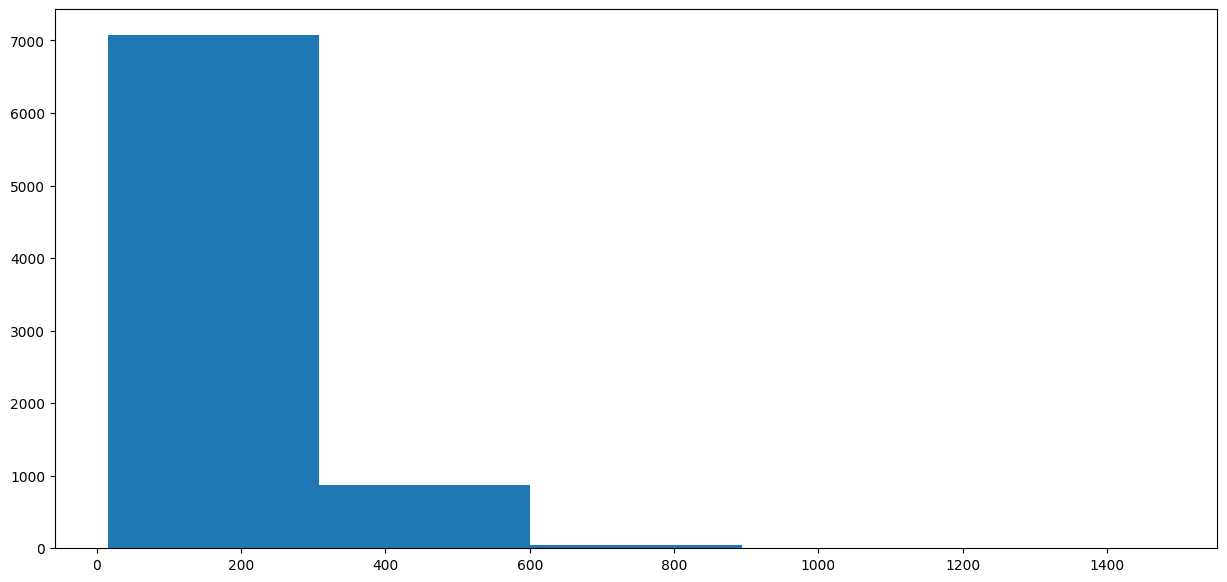

In [375]:
# Посмотрим на распределение длин вакансий
plt.hist(list(map(lambda x: x.shape[0], sentence_embeddings_train)), bins=5)
plt.show()

* Около 90% вакансий имеют длину до 300 символов, поэтому ее и возьмем для параметра 'maxlen'.

In [397]:
# Осуществляем паддинг для нормализации размерностей эмбеддингов
padded_embeddings_train = pad_sequences(sentence_embeddings_train, maxlen=300, padding="post", dtype="float32")
padded_embeddings_val = pad_sequences(sentence_embeddings_val, maxlen=300, padding="post", dtype="float32")
padded_embeddings_test = pad_sequences(sentence_embeddings_test, maxlen=300, padding="post", dtype="float32")

# Меняем формат векторов для корректной работы PyTorch
padded_embeddings_train = torch.tensor(padded_embeddings_train, dtype=torch.float)
padded_embeddings_val = torch.tensor(padded_embeddings_val, dtype=torch.float)
padded_embeddings_test = torch.tensor(padded_embeddings_test, dtype=torch.float)

print(padded_embeddings_train.shape)
print(padded_embeddings_val.shape)
print(padded_embeddings_test.shape)

torch.Size([8000, 300, 300])
torch.Size([1500, 300, 300])
torch.Size([1459, 300, 300])


In [399]:
# Создаем словарь тегов
tag_to_idx = {tag: i for i, tag in enumerate(result_df['tag'].unique())}

# Добавляем тег отсутствия
if "<pad>" not in tag_to_idx:
    tag_to_idx["<pad>"] = len(tag_to_idx) 

# Преобразуем теги в тензоры
grouped_train = train_df['id'].unique()
grouped_val = val_df['id'].unique()
grouped_test = test_df['id'].unique()

tags_sequences_train = []
tags_sequences_val = []
tags_sequences_test = []

for sentence in tqdm(grouped_train):
    sentence_tags = list(train_df[train_df["id"] == sentence]["tag"])
    tags_idx = [tag_to_idx[tag] for tag in sentence_tags]
    tags_tensor = torch.tensor(tags_idx, dtype=torch.long)
    tags_sequences_train.append(tags_tensor)

for sentence in tqdm(grouped_val):
    sentence_tags = list(val_df[val_df["id"] == sentence]["tag"])
    tags_idx = [tag_to_idx[tag] for tag in sentence_tags]
    tags_tensor = torch.tensor(tags_idx, dtype=torch.long)
    tags_sequences_val.append(tags_tensor)

for sentence in tqdm(grouped_test):
    sentence_tags = list(test_df[test_df["id"] == sentence]["tag"])
    tags_idx = [tag_to_idx[tag] for tag in sentence_tags]
    tags_tensor = torch.tensor(tags_idx, dtype=torch.long)
    tags_sequences_test.append(tags_tensor)

# Нормализуем теги
padded_tags_train = pad_sequences(tags_sequences_train, maxlen=300, value=tag_to_idx["<pad>"], padding="post")
padded_tags_val = pad_sequences(tags_sequences_val, maxlen=300, value=tag_to_idx["<pad>"], padding="post")
padded_tags_test = pad_sequences(tags_sequences_test, maxlen=300, value=tag_to_idx["<pad>"], padding="post")

# Меняем формат векторов для корректной работы PyTorch
padded_tags_train = torch.tensor(padded_tags_train, dtype=torch.long)
padded_tags_val = torch.tensor(padded_tags_val, dtype=torch.long)
padded_tags_test = torch.tensor(padded_tags_test, dtype=torch.long)

print(padded_tags_train.shape)
print(padded_tags_val.shape)
print(padded_tags_test.shape)

100%|██████████| 1459/1459 [00:00<00:00, 5417.33it/s]


torch.Size([8000, 300])
torch.Size([1500, 300])
torch.Size([1459, 300])


In [424]:
# Строим архитектуру baseline-модели с одним LSTM-слоем
class NERModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(NERModel, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        tag_space = self.fc(lstm_out.reshape(-1, lstm_out.shape[2]))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores.reshape(x.shape[0], x.shape[1], -1)

In [402]:
# Создаем структуру для подачи в модель
dataset_train = TensorDataset(padded_embeddings_train, padded_tags_train)
dataset_val = TensorDataset(padded_embeddings_val, padded_tags_val)
dataset_test = TensorDataset(padded_embeddings_test, padded_tags_test)

# Создание DataLoader'ов для тренировочного и валидационного наборов
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=32)
test_loader = DataLoader(dataset_test, batch_size=32)

In [403]:
# Обновленная функция для расчета метрик
def calculate_metrics(predictions, true_tags, pad_token_label=3):

    # Преобразование векторов для удобства сравнения
    pred_flat = predictions.view(-1)
    true_flat = true_tags.view(-1)
    
    # Создание маски для отсеивания меток паддинга
    mask = true_flat != pad_token_label
    
    # Применение маски к предсказаниям и истинным меткам
    pred_flat = pred_flat[mask]
    true_flat = true_flat[mask]

    # Расчет метрик
    precision = precision_score(true_flat.cpu(), pred_flat.cpu(), labels=[1, 2], average='weighted')
    recall = recall_score(true_flat.cpu(), pred_flat.cpu(), labels=[1, 2], average='weighted')
    f1 = f1_score(true_flat.cpu(), pred_flat.cpu(), labels=[1, 2], average='weighted')

    return (precision, recall, f1)

In [404]:
# Параметры модели
embedding_dim = 300
hidden_dim = 128
output_dim = len(tag_to_idx)

# Инициализируем модель
model = NERModel(embedding_dim, hidden_dim, output_dim)

# Задаем веса для классов
loss_function = nn.CrossEntropyLoss()

# Определяем оптимизатор с шагом обучения
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Массивы для визуализации обучения
avg_val_loss_lst = []
avg_precision_lst = []
avg_recall_lst = []
avg_f1_lst = []

NUM_EPOCHS = 20
for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0
    
    for embeddings_batch, tags_batch in train_loader:
        optimizer.zero_grad()
        tag_scores = model(embeddings_batch.float())
        loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # Расчет средней потери на тренировочных данных
    avg_train_loss = total_train_loss / len(train_loader)
    
    # Валидация
    model.eval()
    total_val_loss = 0
    precision_list = []
    recall_list = []
    f1_list = []
    
    with torch.no_grad():
        for embeddings_batch, tags_batch in val_loader:
            tag_scores = model(embeddings_batch.float())
            loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
            total_val_loss += loss.item()

            _, predicted_tags = torch.max(tag_scores, dim=2)
            precision, recall, f1 = calculate_metrics(predicted_tags, tags_batch)
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
    
    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_loss_lst.append(avg_val_loss)

    avg_precision = sum(precision_list) / len(precision_list)
    avg_precision_lst.append(avg_precision)

    avg_recall = sum(recall_list) / len(recall_list)
    avg_recall_lst.append(avg_recall)

    avg_f1 = sum(f1_list) / len(f1_list)
    avg_f1_lst.append(avg_f1)
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1: {avg_f1:.4f}')

Epoch 1, Train Loss: 0.1860, Val Loss: 0.0823, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 2, Train Loss: 0.0786, Val Loss: 0.0675, Precision: 0.5480, Recall: 0.0389, F1: 0.0709
Epoch 3, Train Loss: 0.0687, Val Loss: 0.0627, Precision: 0.6332, Recall: 0.0651, F1: 0.1163
Epoch 4, Train Loss: 0.0641, Val Loss: 0.0589, Precision: 0.5787, Recall: 0.1440, F1: 0.2237
Epoch 5, Train Loss: 0.0613, Val Loss: 0.0579, Precision: 0.5451, Recall: 0.1926, F1: 0.2786
Epoch 6, Train Loss: 0.0595, Val Loss: 0.0554, Precision: 0.6212, Recall: 0.1483, F1: 0.2342
Epoch 7, Train Loss: 0.0577, Val Loss: 0.0544, Precision: 0.6051, Recall: 0.1794, F1: 0.2699
Epoch 8, Train Loss: 0.0562, Val Loss: 0.0547, Precision: 0.6484, Recall: 0.1272, F1: 0.2082
Epoch 9, Train Loss: 0.0556, Val Loss: 0.0536, Precision: 0.5805, Recall: 0.2188, F1: 0.3114
Epoch 10, Train Loss: 0.0543, Val Loss: 0.0531, Precision: 0.5819, Recall: 0.2235, F1: 0.3157
Epoch 11, Train Loss: 0.0533, Val Loss: 0.0525, Precision: 0.6265, Re

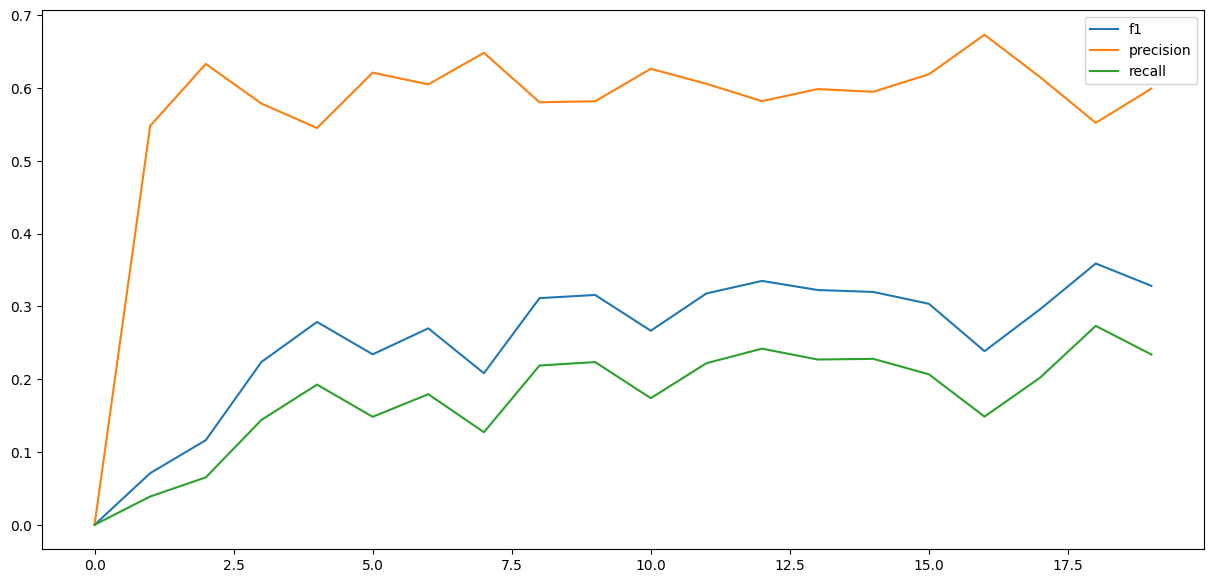

In [405]:
sns.lineplot(x = range(NUM_EPOCHS), y = avg_f1_lst, label="f1")
sns.lineplot(x = range(NUM_EPOCHS), y = avg_precision_lst, label="precision")
sns.lineplot(x = range(NUM_EPOCHS), y = avg_recall_lst, label="recall")
plt.legend()
plt.show()

In [407]:
# Параметры модели
embedding_dim = 300
hidden_dim = 128
output_dim = len(tag_to_idx) 

# Инициализируем модель
model = NERModel(embedding_dim, hidden_dim, output_dim)

# Задаем веса для классов
class_weights = torch.tensor([0.0, 1.0, 1.0, 0.0]) 
loss_function = nn.CrossEntropyLoss(weight=class_weights)

# Определяем оптимизатор с шагом обучения
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Массивы для визуализации обучения
avg_val_loss_lst = []
avg_precision_lst = []
avg_recall_lst = []
avg_f1_lst = []

NUM_EPOCHS = 10
for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0
    
    for embeddings_batch, tags_batch in train_loader:
        optimizer.zero_grad()
        tag_scores = model(embeddings_batch.float())
        loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # Расчет средней потери на тренировочных данных
    avg_train_loss = total_train_loss / len(train_loader)
    
    # Валидация
    model.eval()
    total_val_loss = 0
    precision_list = []
    recall_list = []
    f1_list = []
    
    with torch.no_grad():
        for embeddings_batch, tags_batch in val_loader:
            tag_scores = model(embeddings_batch.float())
            loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
            total_val_loss += loss.item()

            _, predicted_tags = torch.max(tag_scores, dim=2)
            precision, recall, f1 = calculate_metrics(predicted_tags, tags_batch)  
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
    
    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_loss_lst.append(avg_val_loss)

    avg_precision = sum(precision_list) / len(precision_list)
    avg_precision_lst.append(avg_precision)

    avg_recall = sum(recall_list) / len(recall_list)
    avg_recall_lst.append(avg_recall)

    avg_f1 = sum(f1_list) / len(f1_list)
    avg_f1_lst.append(avg_f1)
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1: {avg_f1:.4f}')

Epoch 1, Train Loss: 0.3534, Val Loss: 0.2106, Precision: 0.0301, Recall: 0.9179, F1: 0.0581
Epoch 2, Train Loss: 0.2261, Val Loss: 0.1894, Precision: 0.0304, Recall: 0.9213, F1: 0.0587
Epoch 3, Train Loss: 0.2035, Val Loss: 0.1698, Precision: 0.0316, Recall: 0.9313, F1: 0.0609
Epoch 4, Train Loss: 0.1838, Val Loss: 0.1773, Precision: 0.0369, Recall: 0.9279, F1: 0.0703
Epoch 5, Train Loss: 0.1685, Val Loss: 0.1603, Precision: 0.0328, Recall: 0.9370, F1: 0.0630
Epoch 6, Train Loss: 0.1556, Val Loss: 0.1589, Precision: 0.0321, Recall: 0.9368, F1: 0.0618
Epoch 7, Train Loss: 0.1441, Val Loss: 0.1602, Precision: 0.0362, Recall: 0.9353, F1: 0.0692
Epoch 8, Train Loss: 0.1292, Val Loss: 0.1566, Precision: 0.0338, Recall: 0.9350, F1: 0.0648
Epoch 9, Train Loss: 0.1217, Val Loss: 0.1645, Precision: 0.0370, Recall: 0.9344, F1: 0.0705
Epoch 10, Train Loss: 0.1079, Val Loss: 0.1729, Precision: 0.0381, Recall: 0.9358, F1: 0.0725


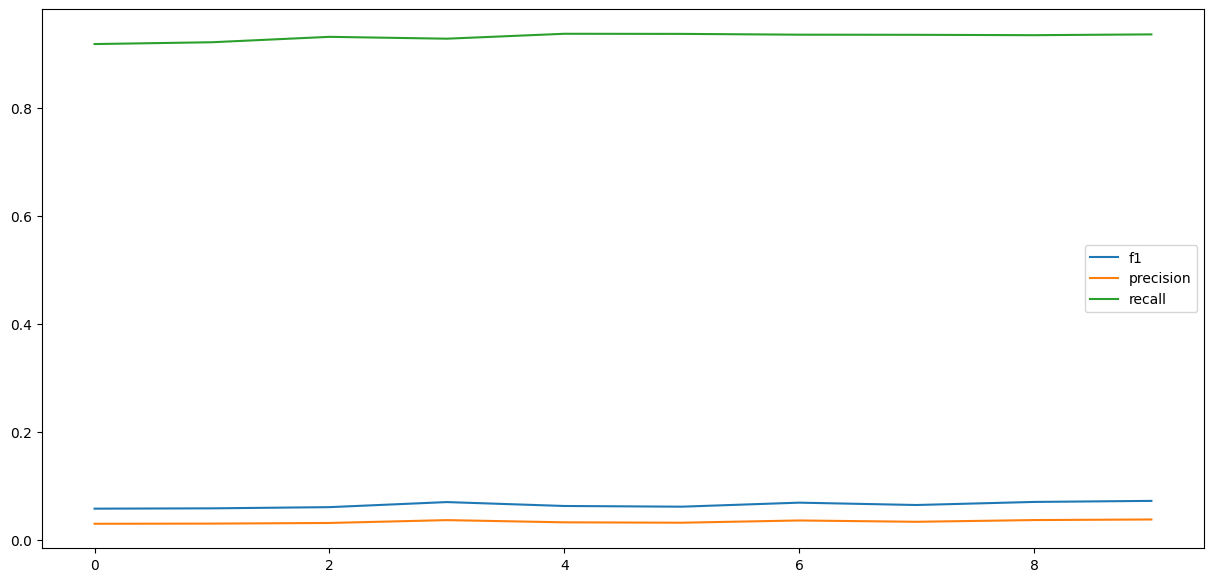

In [408]:
sns.lineplot(x = range(NUM_EPOCHS), y = avg_f1_lst, label="f1")
sns.lineplot(x = range(NUM_EPOCHS), y = avg_precision_lst, label="precision")
sns.lineplot(x = range(NUM_EPOCHS), y = avg_recall_lst, label="recall")
plt.legend()
plt.show()

In [409]:
# Параметры модели
embedding_dim = 300
hidden_dim = 128
output_dim = len(tag_to_idx)

# Инициализируем модель
model = NERModel(embedding_dim, hidden_dim, output_dim)

# Задаем веса для классов
class_weights = torch.tensor([0.1, 1.0, 1.0, 0.0]) 
loss_function = nn.CrossEntropyLoss(weight=class_weights)

# Определяем оптимизатор с шагом обучения
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Массивы для визуализации обучения
avg_val_loss_lst = []
avg_precision_lst = []
avg_recall_lst = []
avg_f1_lst = []

NUM_EPOCHS = 20
for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0
    
    for embeddings_batch, tags_batch in train_loader:
        optimizer.zero_grad()
        tag_scores = model(embeddings_batch.float())
        loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # Расчет средней потери на тренировочных данных
    avg_train_loss = total_train_loss / len(train_loader)
    
    # Валидация
    model.eval()
    total_val_loss = 0
    precision_list = []
    recall_list = []
    f1_list = []
    
    with torch.no_grad():
        for embeddings_batch, tags_batch in val_loader:
            tag_scores = model(embeddings_batch.float())
            loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
            total_val_loss += loss.item()

            _, predicted_tags = torch.max(tag_scores, dim=2)
            precision, recall, f1 = calculate_metrics(predicted_tags, tags_batch) 
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
    
    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_loss_lst.append(avg_val_loss)

    avg_precision = sum(precision_list) / len(precision_list)
    avg_precision_lst.append(avg_precision)

    avg_recall = sum(recall_list) / len(recall_list)
    avg_recall_lst.append(avg_recall)

    avg_f1 = sum(f1_list) / len(f1_list)
    avg_f1_lst.append(avg_f1)
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1: {avg_f1:.4f}')

Epoch 1, Train Loss: 0.5355, Val Loss: 0.4226, Precision: 0.1681, Recall: 0.6777, F1: 0.2658
Epoch 2, Train Loss: 0.4067, Val Loss: 0.3749, Precision: 0.2874, Recall: 0.5281, F1: 0.3646
Epoch 3, Train Loss: 0.3806, Val Loss: 0.3513, Precision: 0.2330, Recall: 0.6804, F1: 0.3413
Epoch 4, Train Loss: 0.3571, Val Loss: 0.3440, Precision: 0.2378, Recall: 0.6942, F1: 0.3498
Epoch 5, Train Loss: 0.3445, Val Loss: 0.3316, Precision: 0.2381, Recall: 0.7217, F1: 0.3546
Epoch 6, Train Loss: 0.3307, Val Loss: 0.3304, Precision: 0.2700, Recall: 0.6719, F1: 0.3817
Epoch 7, Train Loss: 0.3198, Val Loss: 0.3286, Precision: 0.2714, Recall: 0.6655, F1: 0.3813
Epoch 8, Train Loss: 0.3107, Val Loss: 0.3290, Precision: 0.2402, Recall: 0.7185, F1: 0.3557
Epoch 9, Train Loss: 0.3032, Val Loss: 0.3283, Precision: 0.2522, Recall: 0.7099, F1: 0.3686
Epoch 10, Train Loss: 0.2928, Val Loss: 0.3270, Precision: 0.2565, Recall: 0.7062, F1: 0.3724
Epoch 11, Train Loss: 0.2811, Val Loss: 0.3400, Precision: 0.2833, Re

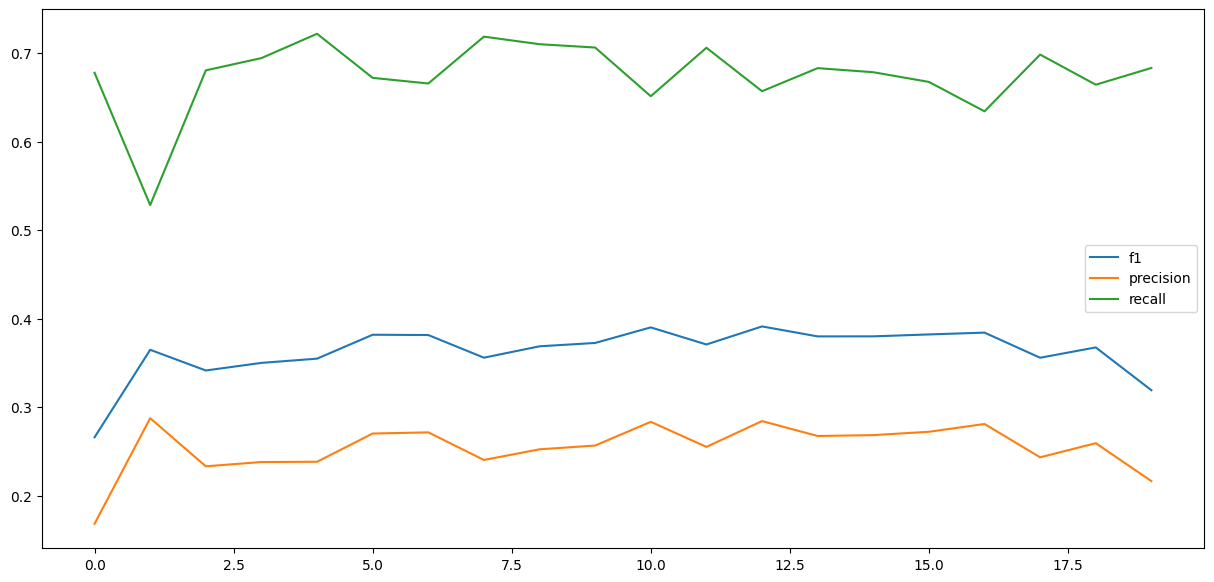

In [410]:
sns.lineplot(x = range(NUM_EPOCHS), y = avg_f1_lst, label="f1")
sns.lineplot(x = range(NUM_EPOCHS), y = avg_precision_lst, label="precision")
sns.lineplot(x = range(NUM_EPOCHS), y = avg_recall_lst, label="recall")
plt.legend()
plt.show()

In [412]:
# Параметры модели
embedding_dim = 300
hidden_dim = 128
output_dim = len(tag_to_idx) 

# Инициализируем модель
model = NERModel(embedding_dim, hidden_dim, output_dim)

# Задаем веса для классов
class_weights = torch.tensor([0.3, 1.0, 1.0, 0.0]) 
loss_function = nn.CrossEntropyLoss(weight=class_weights)

# Определяем оптимизатор с шагом обучения
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Массивы для визуализации обучения
avg_val_loss_lst = []
avg_precision_lst = []
avg_recall_lst = []
avg_f1_lst = []

NUM_EPOCHS = 20
for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0
    
    for embeddings_batch, tags_batch in train_loader:
        optimizer.zero_grad()
        tag_scores = model(embeddings_batch.float())
        loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # Расчет средней потери на тренировочных данных
    avg_train_loss = total_train_loss / len(train_loader)
    
    # Валидация
    model.eval()
    total_val_loss = 0
    precision_list = []
    recall_list = []
    f1_list = []
    
    with torch.no_grad():
        for embeddings_batch, tags_batch in val_loader:
            tag_scores = model(embeddings_batch.float())
            loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
            total_val_loss += loss.item()

            _, predicted_tags = torch.max(tag_scores, dim=2)
            precision, recall, f1 = calculate_metrics(predicted_tags, tags_batch) 
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
    
    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_loss_lst.append(avg_val_loss)

    avg_precision = sum(precision_list) / len(precision_list)
    avg_precision_lst.append(avg_precision)

    avg_recall = sum(recall_list) / len(recall_list)
    avg_recall_lst.append(avg_recall)

    avg_f1 = sum(f1_list) / len(f1_list)
    avg_f1_lst.append(avg_f1)
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1: {avg_f1:.4f}')

Epoch 1, Train Loss: 0.3620, Val Loss: 0.2543, Precision: 0.3297, Recall: 0.2767, F1: 0.2902
Epoch 2, Train Loss: 0.2581, Val Loss: 0.2324, Precision: 0.3421, Recall: 0.3711, F1: 0.3496
Epoch 3, Train Loss: 0.2387, Val Loss: 0.2165, Precision: 0.3722, Recall: 0.3837, F1: 0.3735
Epoch 4, Train Loss: 0.2270, Val Loss: 0.2104, Precision: 0.3509, Recall: 0.4562, F1: 0.3909
Epoch 5, Train Loss: 0.2186, Val Loss: 0.2117, Precision: 0.4176, Recall: 0.4019, F1: 0.4001
Epoch 6, Train Loss: 0.2108, Val Loss: 0.2015, Precision: 0.3947, Recall: 0.4438, F1: 0.4127
Epoch 7, Train Loss: 0.2044, Val Loss: 0.2027, Precision: 0.3763, Recall: 0.4903, F1: 0.4206
Epoch 8, Train Loss: 0.2012, Val Loss: 0.2078, Precision: 0.3721, Recall: 0.5005, F1: 0.4179
Epoch 9, Train Loss: 0.1964, Val Loss: 0.1968, Precision: 0.4006, Recall: 0.4713, F1: 0.4266
Epoch 10, Train Loss: 0.1929, Val Loss: 0.1997, Precision: 0.4357, Recall: 0.4089, F1: 0.4167
Epoch 11, Train Loss: 0.1895, Val Loss: 0.1957, Precision: 0.3863, Re

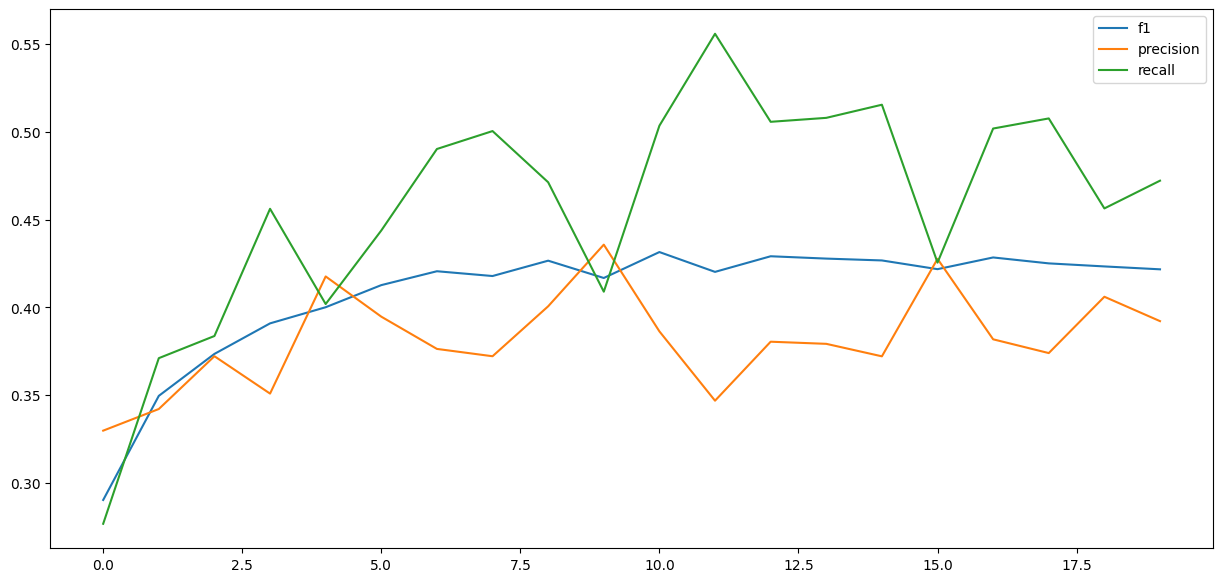

In [413]:
sns.lineplot(x = range(NUM_EPOCHS), y = avg_f1_lst, label="f1")
sns.lineplot(x = range(NUM_EPOCHS), y = avg_precision_lst, label="precision")
sns.lineplot(x = range(NUM_EPOCHS), y = avg_recall_lst, label="recall")
plt.legend()
plt.show()

In [414]:
# Параметры модели
embedding_dim = 300
hidden_dim = 128
output_dim = len(tag_to_idx) 

# Инициализируем модель
model = NERModel(embedding_dim, hidden_dim, output_dim)

# Задаем веса для классов
class_weights = torch.tensor([0.3, 1.0, 1.0, 0.0]) 
loss_function = nn.CrossEntropyLoss(weight=class_weights)

# Определяем оптимизатор с шагом обучения
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Массивы для визуализации обучения
avg_val_loss_lst = []
avg_precision_lst = []
avg_recall_lst = []
avg_f1_lst = []

NUM_EPOCHS = 10
for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0
    
    for embeddings_batch, tags_batch in train_loader:
        optimizer.zero_grad()
        tag_scores = model(embeddings_batch.float())
        loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # Расчет средней потери на тренировочных данных
    avg_train_loss = total_train_loss / len(train_loader)
    
    # Валидация
    model.eval()
    total_val_loss = 0
    precision_list = []
    recall_list = []
    f1_list = []
    
    with torch.no_grad():
        for embeddings_batch, tags_batch in val_loader:
            tag_scores = model(embeddings_batch.float())
            loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
            total_val_loss += loss.item()

            _, predicted_tags = torch.max(tag_scores, dim=2)
            precision, recall, f1 = calculate_metrics(predicted_tags, tags_batch) 
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
    
    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_loss_lst.append(avg_val_loss)

    avg_precision = sum(precision_list) / len(precision_list)
    avg_precision_lst.append(avg_precision)

    avg_recall = sum(recall_list) / len(recall_list)
    avg_recall_lst.append(avg_recall)

    avg_f1 = sum(f1_list) / len(f1_list)
    avg_f1_lst.append(avg_f1)
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1: {avg_f1:.4f}')

Epoch 1, Train Loss: 0.3527, Val Loss: 0.2554, Precision: 0.3866, Recall: 0.2340, F1: 0.2852
Epoch 2, Train Loss: 0.2536, Val Loss: 0.2329, Precision: 0.3519, Recall: 0.3785, F1: 0.3594
Epoch 3, Train Loss: 0.2336, Val Loss: 0.2218, Precision: 0.3362, Recall: 0.4398, F1: 0.3763
Epoch 4, Train Loss: 0.2226, Val Loss: 0.2099, Precision: 0.3435, Recall: 0.4950, F1: 0.4002
Epoch 5, Train Loss: 0.2154, Val Loss: 0.2042, Precision: 0.3654, Recall: 0.4961, F1: 0.4149
Epoch 6, Train Loss: 0.2089, Val Loss: 0.2128, Precision: 0.4596, Recall: 0.3374, F1: 0.3816
Epoch 7, Train Loss: 0.2048, Val Loss: 0.2010, Precision: 0.3464, Recall: 0.5428, F1: 0.4178
Epoch 8, Train Loss: 0.1990, Val Loss: 0.1981, Precision: 0.3845, Recall: 0.4887, F1: 0.4201
Epoch 9, Train Loss: 0.1946, Val Loss: 0.1942, Precision: 0.3948, Recall: 0.4876, F1: 0.4312
Epoch 10, Train Loss: 0.1936, Val Loss: 0.1968, Precision: 0.4041, Recall: 0.4659, F1: 0.4277


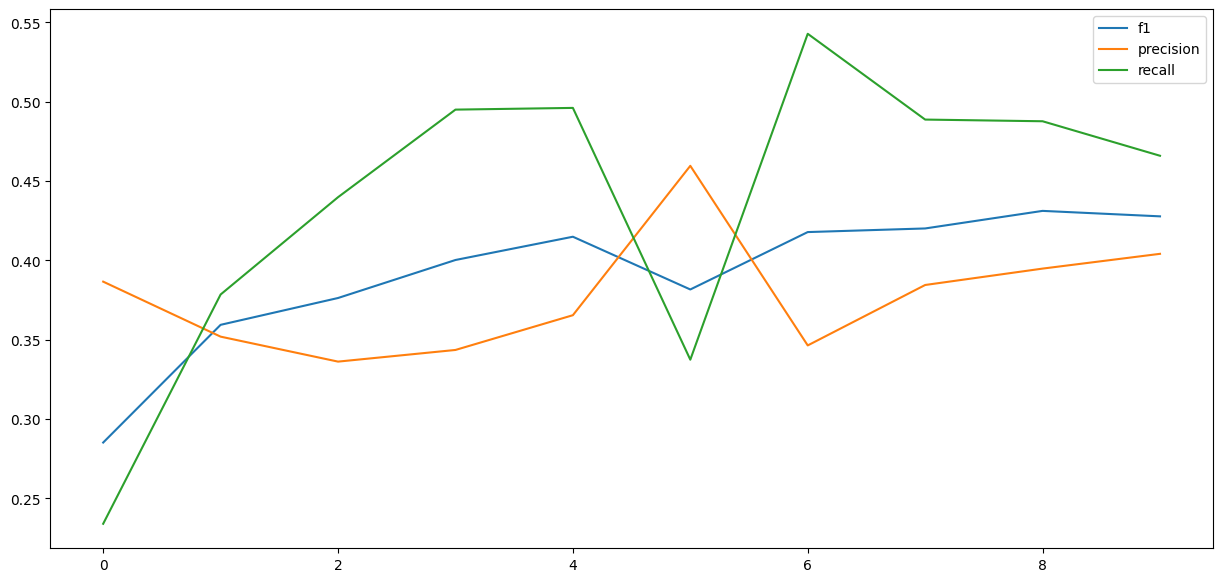

In [415]:
sns.lineplot(x = range(NUM_EPOCHS), y = avg_f1_lst, label="f1")
sns.lineplot(x = range(NUM_EPOCHS), y = avg_precision_lst, label="precision")
sns.lineplot(x = range(NUM_EPOCHS), y = avg_recall_lst, label="recall")
plt.legend()
plt.show()

* Мы выяснили, что распределение весов [0.3, 1.0, 1.0] для расчета кросс-энтропии является оптимальным с точки зрения разброса между Precision и Recall. С такими весами продолжим моделирование и для других архитектур.

In [416]:
# Проверим модель из сверточного слоя
class NERModelConv1D(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(NERModelConv1D, self).__init__()
        self.conv1d = nn.Conv1d(in_channels=embedding_dim, out_channels=hidden_dim, kernel_size=3, padding=1)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Переставляем размерности, потому что Conv1d ожидает (batch_size, channels, seq_length)
        x = x.permute(0, 2, 1)
        conv_out = self.conv1d(x)
        
        # Переставляем обратно, чтобы размерности соответствовали ожиданиям Linear и дальнейшей обработке
        conv_out = conv_out.permute(0, 2, 1)
        
        # Развертывание для линейного слоя
        tag_space = self.fc(conv_out.reshape(-1, conv_out.shape[2]))
        tag_scores = F.log_softmax(tag_space, dim=1)
        
        # Возвращаем к исходной размерности batch_size x seq_length x output_dim
        return tag_scores.reshape(x.shape[0], x.shape[2], -1)

In [417]:
# Параметры модели
embedding_dim = 300
hidden_dim = 128
output_dim = len(tag_to_idx)

# Инициализируем модель
model = NERModelConv1D(embedding_dim, hidden_dim, output_dim)

# Задаем веса для классов
class_weights = torch.tensor([0.3, 1.0, 1.0, 0.0]) 
loss_function = nn.CrossEntropyLoss(weight=class_weights)

# Определяем оптимизатор с шагом обучения
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Массивы для визуализации обучения
avg_val_loss_lst = []
avg_precision_lst = []
avg_recall_lst = []
avg_f1_lst = []

NUM_EPOCHS = 20
for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0
    
    for embeddings_batch, tags_batch in train_loader:
        optimizer.zero_grad()
        tag_scores = model(embeddings_batch.float())
        loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # Расчет средней потери на тренировочных данных
    avg_train_loss = total_train_loss / len(train_loader)
    
    # Валидация
    model.eval()
    total_val_loss = 0
    precision_list = []
    recall_list = []
    f1_list = []
    
    with torch.no_grad():
        for embeddings_batch, tags_batch in val_loader:
            tag_scores = model(embeddings_batch.float())
            loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
            total_val_loss += loss.item()

            _, predicted_tags = torch.max(tag_scores, dim=2)
            precision, recall, f1 = calculate_metrics(predicted_tags, tags_batch)
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
    
    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_loss_lst.append(avg_val_loss)

    avg_precision = sum(precision_list) / len(precision_list)
    avg_precision_lst.append(avg_precision)

    avg_recall = sum(recall_list) / len(recall_list)
    avg_recall_lst.append(avg_recall)

    avg_f1 = sum(f1_list) / len(f1_list)
    avg_f1_lst.append(avg_f1)
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1: {avg_f1:.4f}')

Epoch 1, Train Loss: 0.3520, Val Loss: 0.2837, Precision: 0.3060, Recall: 0.2569, F1: 0.2739
Epoch 2, Train Loss: 0.2932, Val Loss: 0.2682, Precision: 0.3529, Recall: 0.2530, F1: 0.2898
Epoch 3, Train Loss: 0.2837, Val Loss: 0.2652, Precision: 0.3886, Recall: 0.2151, F1: 0.2689
Epoch 4, Train Loss: 0.2795, Val Loss: 0.2599, Precision: 0.3593, Recall: 0.2370, F1: 0.2802
Epoch 5, Train Loss: 0.2765, Val Loss: 0.2585, Precision: 0.3648, Recall: 0.2858, F1: 0.3154
Epoch 6, Train Loss: 0.2766, Val Loss: 0.2570, Precision: 0.3998, Recall: 0.2639, F1: 0.3105
Epoch 7, Train Loss: 0.2730, Val Loss: 0.2558, Precision: 0.3887, Recall: 0.2782, F1: 0.3179
Epoch 8, Train Loss: 0.2746, Val Loss: 0.2562, Precision: 0.4100, Recall: 0.2365, F1: 0.2930
Epoch 9, Train Loss: 0.2734, Val Loss: 0.2543, Precision: 0.3958, Recall: 0.2763, F1: 0.3178
Epoch 10, Train Loss: 0.2741, Val Loss: 0.2592, Precision: 0.4179, Recall: 0.2006, F1: 0.2642
Epoch 11, Train Loss: 0.2716, Val Loss: 0.2538, Precision: 0.4094, Re

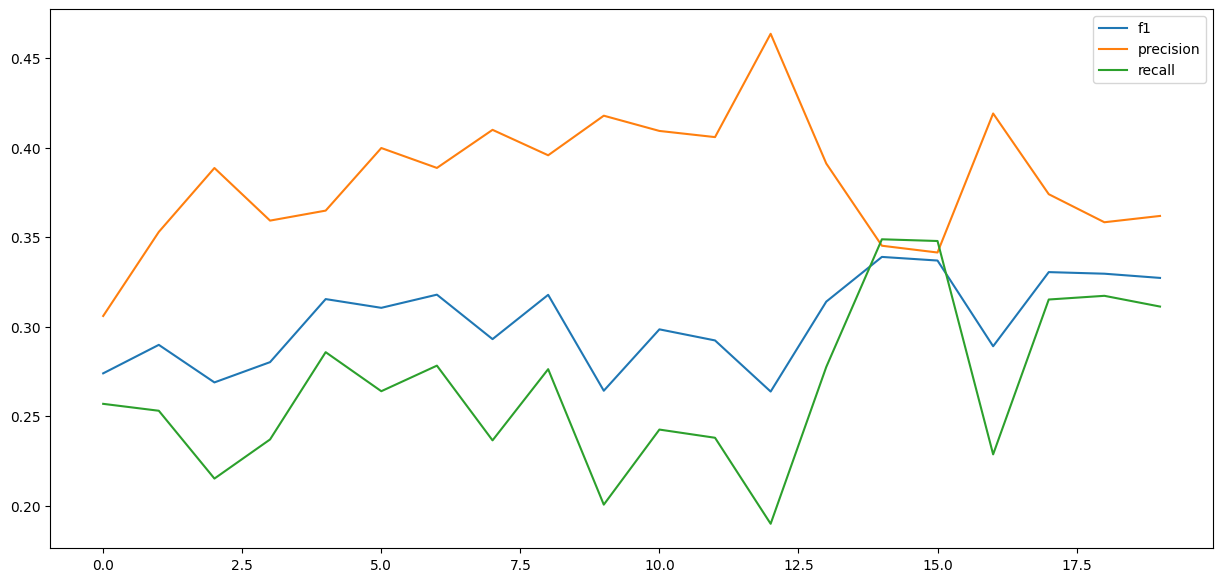

In [418]:
sns.lineplot(x = range(NUM_EPOCHS), y = avg_f1_lst, label="f1")
sns.lineplot(x = range(NUM_EPOCHS), y = avg_precision_lst, label="precision")
sns.lineplot(x = range(NUM_EPOCHS), y = avg_recall_lst, label="recall")
plt.legend()
plt.show()

In [425]:
# Строим архитектуру baseline-модели с одним LSTM-слоем
class BiLSTMModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        tag_space = self.fc(lstm_out.reshape(-1, lstm_out.shape[2]))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores.reshape(x.shape[0], x.shape[1], -1)

In [426]:
# Параметры модели
embedding_dim = 300
hidden_dim = 256
output_dim = len(tag_to_idx) 

# Инициализируем модель
model = BiLSTMModel(embedding_dim, hidden_dim, output_dim)

# Задаем веса для классов
class_weights = torch.tensor([0.3, 1.0, 1.0, 0.0]) 
loss_function = nn.CrossEntropyLoss(weight=class_weights)

# Определяем оптимизатор с шагом обучения
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Массивы для визуализации обучения
avg_val_loss_lst = []
avg_precision_lst = []
avg_recall_lst = []
avg_f1_lst = []

NUM_EPOCHS = 10
for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0
    
    for embeddings_batch, tags_batch in train_loader:
        optimizer.zero_grad()
        tag_scores = model(embeddings_batch.float())
        loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # Расчет средней потери на тренировочных данных
    avg_train_loss = total_train_loss / len(train_loader)
    
    # Валидация
    model.eval()
    total_val_loss = 0
    precision_list = []
    recall_list = []
    f1_list = []
    
    with torch.no_grad():
        for embeddings_batch, tags_batch in val_loader:
            tag_scores = model(embeddings_batch.float())
            loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
            total_val_loss += loss.item()

            _, predicted_tags = torch.max(tag_scores, dim=2)
            precision, recall, f1 = calculate_metrics(predicted_tags, tags_batch) 
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
    
    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_loss_lst.append(avg_val_loss)

    avg_precision = sum(precision_list) / len(precision_list)
    avg_precision_lst.append(avg_precision)

    avg_recall = sum(recall_list) / len(recall_list)
    avg_recall_lst.append(avg_recall)

    avg_f1 = sum(f1_list) / len(f1_list)
    avg_f1_lst.append(avg_f1)
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1: {avg_f1:.4f}')

Epoch 1, Train Loss: 0.3183, Val Loss: 0.2327, Precision: 0.3468, Recall: 0.4193, F1: 0.3664
Epoch 2, Train Loss: 0.2336, Val Loss: 0.2028, Precision: 0.4383, Recall: 0.4158, F1: 0.4199
Epoch 3, Train Loss: 0.2105, Val Loss: 0.1933, Precision: 0.4366, Recall: 0.4700, F1: 0.4475
Epoch 4, Train Loss: 0.2018, Val Loss: 0.1929, Precision: 0.3937, Recall: 0.5537, F1: 0.4520
Epoch 5, Train Loss: 0.1909, Val Loss: 0.1870, Precision: 0.4246, Recall: 0.5178, F1: 0.4583
Epoch 6, Train Loss: 0.1837, Val Loss: 0.1843, Precision: 0.4232, Recall: 0.5350, F1: 0.4675
Epoch 7, Train Loss: 0.1735, Val Loss: 0.1855, Precision: 0.4150, Recall: 0.5389, F1: 0.4632
Epoch 8, Train Loss: 0.1659, Val Loss: 0.1890, Precision: 0.4094, Recall: 0.5509, F1: 0.4634
Epoch 9, Train Loss: 0.1537, Val Loss: 0.1910, Precision: 0.4248, Recall: 0.5270, F1: 0.4652
Epoch 10, Train Loss: 0.1414, Val Loss: 0.2002, Precision: 0.4056, Recall: 0.5314, F1: 0.4547


In [429]:
class CNNBiLSTMModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(CNNBiLSTMModel, self).__init__()
        self.conv1d = nn.Conv1d(in_channels=embedding_dim, out_channels=hidden_dim, kernel_size=3, padding=1)
        # После сверточного слоя выход будет иметь размерность hidden_dim, поэтому в LSTM она будет hidden_dim
        self.bilstm = nn.LSTM(hidden_dim, hidden_dim // 2, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Переставляем размерности для Conv1d
        x = x.permute(0, 2, 1)
        conv_out = self.conv1d(x)
        
        # Переставляем обратно размерности для подачи в LSTM
        conv_out = conv_out.permute(0, 2, 1)
        
        # Пропускаем через BiLSTM
        lstm_out, _ = self.bilstm(conv_out)
        
        # Подаем на полносвязный слой
        tag_space = self.fc(lstm_out.reshape(-1, lstm_out.shape[2]))
        tag_scores = F.log_softmax(tag_space, dim=1)
        
        # Возвращаем к размерности batch_size x seq_length x output_dim
        return tag_scores.reshape(x.shape[0], x.shape[2], -1)

In [430]:
# Параметры модели
embedding_dim = 300
hidden_dim = 256
output_dim = len(tag_to_idx)

# Инициализируем модель
model = CNNBiLSTMModel(embedding_dim, hidden_dim, output_dim)

# Задаем веса для классов
class_weights = torch.tensor([0.3, 1.0, 1.0, 0.0]) 
loss_function = nn.CrossEntropyLoss(weight=class_weights)

# Определяем оптимизатор с шагом обучения
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Массивы для визуализации обучения
avg_val_loss_lst = []
avg_precision_lst = []
avg_recall_lst = []
avg_f1_lst = []

NUM_EPOCHS = 15
for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0
    
    for embeddings_batch, tags_batch in train_loader:
        optimizer.zero_grad()
        tag_scores = model(embeddings_batch.float())
        loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # Расчет средней потери на тренировочных данных
    avg_train_loss = total_train_loss / len(train_loader)
    
    # Валидация
    model.eval()
    total_val_loss = 0
    precision_list = []
    recall_list = []
    f1_list = []
    
    with torch.no_grad():
        for embeddings_batch, tags_batch in val_loader:
            tag_scores = model(embeddings_batch.float())
            loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
            total_val_loss += loss.item()

            _, predicted_tags = torch.max(tag_scores, dim=2)
            precision, recall, f1 = calculate_metrics(predicted_tags, tags_batch) 
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
    
    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_loss_lst.append(avg_val_loss)

    avg_precision = sum(precision_list) / len(precision_list)
    avg_precision_lst.append(avg_precision)

    avg_recall = sum(recall_list) / len(recall_list)
    avg_recall_lst.append(avg_recall)

    avg_f1 = sum(f1_list) / len(f1_list)
    avg_f1_lst.append(avg_f1)
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1: {avg_f1:.4f}')

Epoch 1, Train Loss: 0.3042, Val Loss: 0.2325, Precision: 0.3422, Recall: 0.4003, F1: 0.3620
Epoch 2, Train Loss: 0.2317, Val Loss: 0.2055, Precision: 0.4425, Recall: 0.3776, F1: 0.4019
Epoch 3, Train Loss: 0.2115, Val Loss: 0.1988, Precision: 0.4998, Recall: 0.3579, F1: 0.4112
Epoch 4, Train Loss: 0.2038, Val Loss: 0.2012, Precision: 0.3952, Recall: 0.4878, F1: 0.4258
Epoch 5, Train Loss: 0.1953, Val Loss: 0.1927, Precision: 0.4084, Recall: 0.5188, F1: 0.4508
Epoch 6, Train Loss: 0.1855, Val Loss: 0.1875, Precision: 0.4198, Recall: 0.5282, F1: 0.4622
Epoch 7, Train Loss: 0.1803, Val Loss: 0.1970, Precision: 0.4647, Recall: 0.4447, F1: 0.4485
Epoch 8, Train Loss: 0.1702, Val Loss: 0.1911, Precision: 0.4004, Recall: 0.5513, F1: 0.4581
Epoch 9, Train Loss: 0.1649, Val Loss: 0.1955, Precision: 0.4142, Recall: 0.5202, F1: 0.4524
Epoch 10, Train Loss: 0.1554, Val Loss: 0.1988, Precision: 0.4439, Recall: 0.4799, F1: 0.4543
Epoch 11, Train Loss: 0.1464, Val Loss: 0.2056, Precision: 0.3474, Re

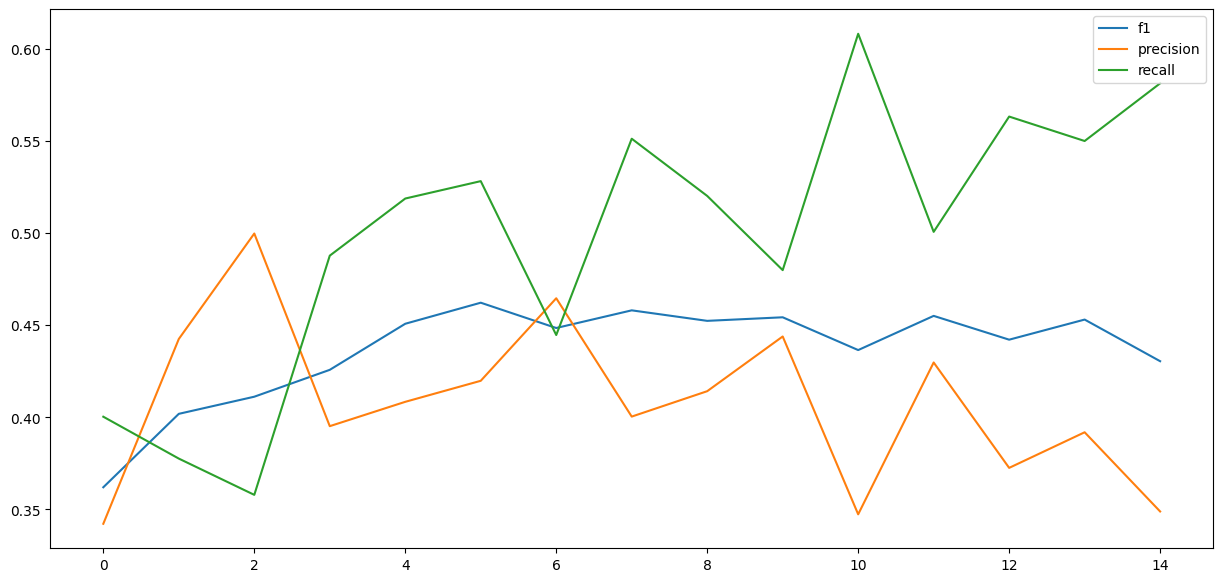

In [431]:
sns.lineplot(x = range(NUM_EPOCHS), y = avg_f1_lst, label="f1")
sns.lineplot(x = range(NUM_EPOCHS), y = avg_precision_lst, label="precision")
sns.lineplot(x = range(NUM_EPOCHS), y = avg_recall_lst, label="recall")
plt.legend()
plt.show()

In [441]:
class DeepCNNBiLSTMModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(DeepCNNBiLSTMModel, self).__init__()
        # Сверточные слои
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=3, padding=1)
        # Двунаправленный LSTM
        self.bilstm = nn.LSTM(hidden_dim, hidden_dim, num_layers=2, batch_first=True, bidirectional=True, dropout=0.5)
        # Полносвязный слой
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    
    def forward(self, x):
        # Переставляем размерности для Conv1d (batch_size, embedding_dim, seq_length)
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        # Переставляем обратно размерности для LSTM (batch_size, seq_length, hidden_dim)
        x = x.permute(0, 2, 1)
        # LSTM слой
        lstm_out, _ = self.bilstm(x)
        # Применяем полносвязный слой (batch_size * seq_length, hidden_dim * 2)
        tag_space = self.fc(lstm_out.contiguous().view(-1, lstm_out.shape[2]))
        tag_scores = F.log_softmax(tag_space, dim=1)
        # Возвращаем к размерности (batch_size, seq_length, output_dim)
        return tag_scores.view(x.shape[0], x.shape[1], -1)

In [442]:
# Параметры модели
embedding_dim = 300
hidden_dim = 256
output_dim = len(tag_to_idx) 

# Инициализируем модель
model = DeepCNNBiLSTMModel(embedding_dim, hidden_dim, output_dim)

# Задаем веса для классов
class_weights = torch.tensor([0.35, 1.0, 1.0, 0.0]) 
loss_function = nn.CrossEntropyLoss(weight=class_weights)

# Определяем оптимизатор с шагом обучения
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Массивы для визуализации обучения
avg_val_loss_lst = []
avg_precision_lst = []
avg_recall_lst = []
avg_f1_lst = []

NUM_EPOCHS = 10
for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0
    
    for embeddings_batch, tags_batch in train_loader:
        optimizer.zero_grad()
        tag_scores = model(embeddings_batch.float())
        loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # Расчет средней потери на тренировочных данных
    avg_train_loss = total_train_loss / len(train_loader)
    
    # Валидация
    model.eval()
    total_val_loss = 0
    precision_list = []
    recall_list = []
    f1_list = []
    
    with torch.no_grad():
        for embeddings_batch, tags_batch in val_loader:
            tag_scores = model(embeddings_batch.float())
            loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
            total_val_loss += loss.item()

            _, predicted_tags = torch.max(tag_scores, dim=2)
            precision, recall, f1 = calculate_metrics(predicted_tags, tags_batch) 
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
    
    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_loss_lst.append(avg_val_loss)

    avg_precision = sum(precision_list) / len(precision_list)
    avg_precision_lst.append(avg_precision)

    avg_recall = sum(recall_list) / len(recall_list)
    avg_recall_lst.append(avg_recall)

    avg_f1 = sum(f1_list) / len(f1_list)
    avg_f1_lst.append(avg_f1)
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1: {avg_f1:.4f}')

Epoch 1, Train Loss: 0.2984, Val Loss: 0.1979, Precision: 0.4178, Recall: 0.3733, F1: 0.3794
Epoch 2, Train Loss: 0.2050, Val Loss: 0.1863, Precision: 0.4641, Recall: 0.3776, F1: 0.4029
Epoch 3, Train Loss: 0.1869, Val Loss: 0.1889, Precision: 0.5552, Recall: 0.3425, F1: 0.4149
Epoch 4, Train Loss: 0.1765, Val Loss: 0.1810, Precision: 0.3955, Recall: 0.5491, F1: 0.4551
Epoch 5, Train Loss: 0.1654, Val Loss: 0.1761, Precision: 0.4246, Recall: 0.5155, F1: 0.4604
Epoch 6, Train Loss: 0.1550, Val Loss: 0.1793, Precision: 0.4568, Recall: 0.4654, F1: 0.4547
Epoch 7, Train Loss: 0.1445, Val Loss: 0.1857, Precision: 0.3713, Recall: 0.5649, F1: 0.4428
Epoch 8, Train Loss: 0.1345, Val Loss: 0.1900, Precision: 0.3698, Recall: 0.5707, F1: 0.4442
Epoch 9, Train Loss: 0.1221, Val Loss: 0.2023, Precision: 0.4240, Recall: 0.4916, F1: 0.4504
Epoch 10, Train Loss: 0.1072, Val Loss: 0.2242, Precision: 0.4487, Recall: 0.4521, F1: 0.4448


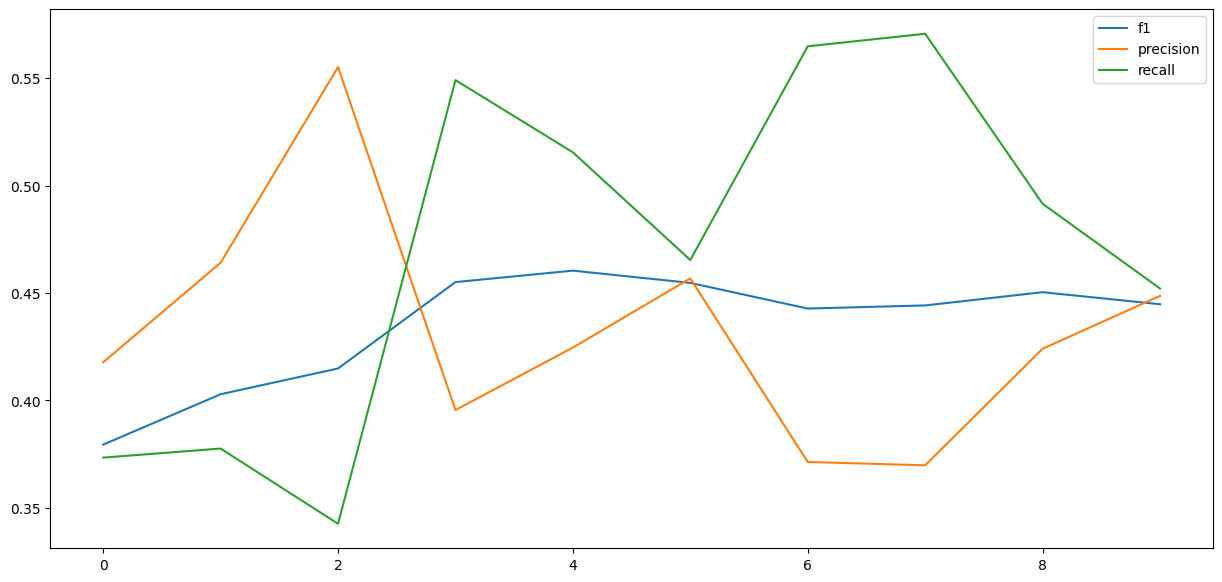

In [443]:
sns.lineplot(x = range(NUM_EPOCHS), y = avg_f1_lst, label="f1")
sns.lineplot(x = range(NUM_EPOCHS), y = avg_precision_lst, label="precision")
sns.lineplot(x = range(NUM_EPOCHS), y = avg_recall_lst, label="recall")
plt.legend()
plt.show()

In [253]:
def flatten_predictions(predictions, true_tags, pad_idx):
    flat_predictions = []
    flat_true_tags = []

    for pred_seq, true_seq in zip(predictions, true_tags):
        for pred, true in zip(pred_seq, true_seq):
            if true != pad_idx:
                flat_predictions.append(pred)
                flat_true_tags.append(true)

    return flat_predictions, flat_true_tags

def calculate_metrics(predictions, true_tags, pad_idx):
    flat_predictions, flat_true_tags = flatten_predictions(predictions, true_tags, pad_idx)

    precision = precision_score(flat_true_tags, flat_predictions, average='weighted')
    recall = recall_score(flat_true_tags, flat_predictions, average='weighted')
    f1 = f1_score(flat_true_tags, flat_predictions, average='weighted')

    return (precision, recall, f1)

In [444]:
from TorchCRF import CRF

class DeepCNNBiLSTMCRFModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, pad_idx):
        super(DeepCNNBiLSTMCRFModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=3, padding=1)
        # self.pool = nn.MaxPool1d(2, stride=1)
        self.bilstm = nn.LSTM(hidden_dim, hidden_dim // 2, num_layers=2, batch_first=True, bidirectional=True, dropout=0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.crf = CRF(output_dim)
        self.pad_idx = pad_idx
    
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        # x = self.pool(x)
        x = x.permute(0, 2, 1)
        lstm_out, _ = self.bilstm(x)
        emissions = self.fc(lstm_out)
        return emissions
    
    def loss(self, emissions, tags, mask):
        loss = -self.crf(emissions, tags, mask=mask)
        return loss.mean()

    def decode(self, emissions, mask):
        return self.crf.viterbi_decode(emissions, mask=mask)

pad_idx = tag_to_idx["<pad>"]

# Параметры модели
embedding_dim = 300
hidden_dim = 256
output_dim = len(tag_to_idx)

# Инициализируем модель
model = DeepCNNBiLSTMCRFModel(embedding_dim, hidden_dim, output_dim, pad_idx)

# Определяем оптимизатор
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [448]:
# Массивы для визуализации обучения
avg_val_loss_lst = []
avg_precision_lst = []
avg_recall_lst = []
avg_f1_lst = []

NUM_EPOCHS = 15
for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0
    
    for embeddings_batch, tags_batch in train_loader:
        optimizer.zero_grad()
        emissions = model(embeddings_batch.float())
        mask = tags_batch != tag_to_idx["<pad>"]
        loss = model.loss(emissions, tags_batch, mask)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    
    # Валидация
    model.eval()
    total_val_loss = 0
    precision_list = []
    recall_list = []
    f1_list = []
    
    with torch.no_grad():
        for embeddings_batch, tags_batch in val_loader:
            emissions = model(embeddings_batch.float())
            mask = tags_batch != tag_to_idx["<pad>"]
            loss = model.loss(emissions, tags_batch, mask)
            total_val_loss += loss.item()

            predicted_tags = model.decode(emissions, mask)
            precision, recall, f1 = calculate_metrics(predicted_tags, tags_batch)
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
    
    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_loss_lst.append(avg_val_loss)

    avg_precision = sum(precision_list) / len(precision_list)
    avg_precision_lst.append(avg_precision)

    avg_recall = sum(recall_list) / len(recall_list)
    avg_recall_lst.append(avg_recall)

    avg_f1 = sum(f1_list) / len(f1_list)
    avg_f1_lst.append(avg_f1)
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1: {avg_f1:.4f}')

Epoch 1, Train Loss: 0.2870, Val Loss: 0.2606, Precision: 41.05%, Recall: 43.10%, F1: 41.91%
Epoch 2, Train Loss: 0.2756, Val Loss: 0.2644, Precision: 42.01%, Recall: 44.09%, F1: 42.98%
Epoch 3, Train Loss: 0.2635, Val Loss: 0.2527, Precision: 42.84%, Recall: 44.92%, F1: 43.80%
Epoch 4, Train Loss: 0.2610, Val Loss: 0.2475, Precision: 43.76%, Recall: 45.73%, F1: 44.64%
Epoch 5, Train Loss: 0.2475, Val Loss: 0.2240, Precision: 44.96%, Recall: 46.71%, F1: 45.81%
Epoch 6, Train Loss: 0.2383, Val Loss: 0.2161, Precision: 45.90%, Recall: 47.73%, F1: 46.77%
Epoch 7, Train Loss: 0.2303, Val Loss: 0.2095, Precision: 46.80%, Recall: 48.72%, F1: 47.79%
Epoch 8, Train Loss: 0.2176, Val Loss: 0.1909, Precision: 47.62%, Recall: 49.91%, F1: 48.66%
Epoch 9, Train Loss: 0.2046, Val Loss: 0.1930, Precision: 48.69%, Recall: 50.81%, F1: 49.61%
Epoch 10, Train Loss: 0.1916, Val Loss: 0.1749, Precision: 49.56%, Recall: 51.94%, F1: 50.72%
Epoch 11, Train Loss: 0.1845, Val Loss: 0.1550, Precision: 50.39%, Re